In [1]:
import os
import torch
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda


In [17]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
song_name = 'Creepoid_OldTree'

# track is the sum of preprocessed stems
track_path = os.path.join(base_dir, song_name, '{}_SUM.wav'.format(song_name))
audio, sr = sf.read(track_path, always_2d=True)

# the track is mono, duplicate channels as both source separation
# models want stereo input (or, at least a 2D shape)
if audio.shape[1] == 1:
    audio = np.repeat(audio, 2, axis=1)

# Phase 1: Source Separation
---

**Input track**: sum of preprocessed stems (unmixed sum)

We want to split the track in 4 stems: `bass`, `drums`, `vocals`, `other` and remix them using the mixing model

In [23]:
import sys
from spleeter.separator import Separator

sys.path.append("./open_unmix_pytorch")
from open_unmix_pytorch import test

In [11]:
def sum_separated_tracks(split, sr, write_to_disk=True, results_dir=None):
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # we can choose any track for reference, all have the same shape
    sum_track = np.zeros_like(split['drums'])
        
    for track_name, track in split.items():
        sum_track += split[track_name]
        if write_to_disk:
            sf.write(os.path.join(results_dir, '{}.wav'.format(track_name)), track, sr)

    if write_to_disk:
        sf.write(os.path.join(results_dir, 'sum.wav'), sum_track, sr)
    
    return sum_track

def visualize_spectrum(gt_audio, sum_track, title):
    plt.figure(figsize=(16, 8))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    sum_spectr = librosa.stft(librosa.to_mono(sum_track.T))
    spec = librosa.amplitude_to_db(np.abs(sum_spectr))
    librosa.display.specshow(spec, y_axis='linear')
    plt.title('Spectrogram of the sum')

    plt.subplot(1, 2, 2)
    orig_spectr = librosa.stft(librosa.to_mono(gt_audio.T))
    spec = librosa.amplitude_to_db(np.abs(orig_spectr))
    librosa.display.specshow(spec, y_axis='linear')
    plt.title('Spectrogram of the original track')

    plt.show()

## Deezer Spleeter

In [6]:
# during the first run, a pretrained model (around 160mb)
# will be downloaded and placed into "./pretrained_models"

# Note: the model occupies around 3Gb of RAM
separator = Separator('spleeter:4stems')
split_spleeter = separator.separate(audio)

INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram


INFO:tensorflow:Restoring parameters from pretrained_models/4stems/model


In [10]:
results_dir = os.path.join('output', 'spleeter', song_name)
sum_spleeter = sum_separated_tracks(split_spleeter, sr, results_dir=results_dir)

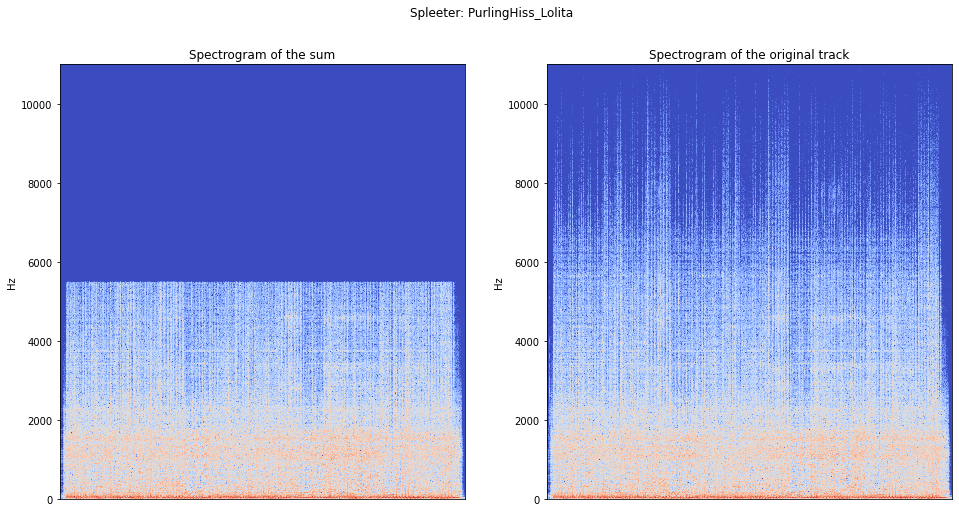

In [12]:
visualize_spectrum(audio, sum_spleeter, 'Spleeter: {}'.format(song_name))

## Open-unmix

In [24]:
# Note: this piece of software is even more greedy and causes spikes
# of RAM usage around 6-7Gb

split_open_unmix = test.separate(
    audio=audio, 
    targets=['vocals', 'drums', 'bass', 'other'],
    model_name='umxhq',
    residual_model=False,
    niter=1,
    device=device
)

100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


In [27]:
results_dir = os.path.join('output', 'open-unmix', song_name)
sum_open_unmix = sum_separated_tracks(split_open_unmix, sr, results_dir=results_dir)

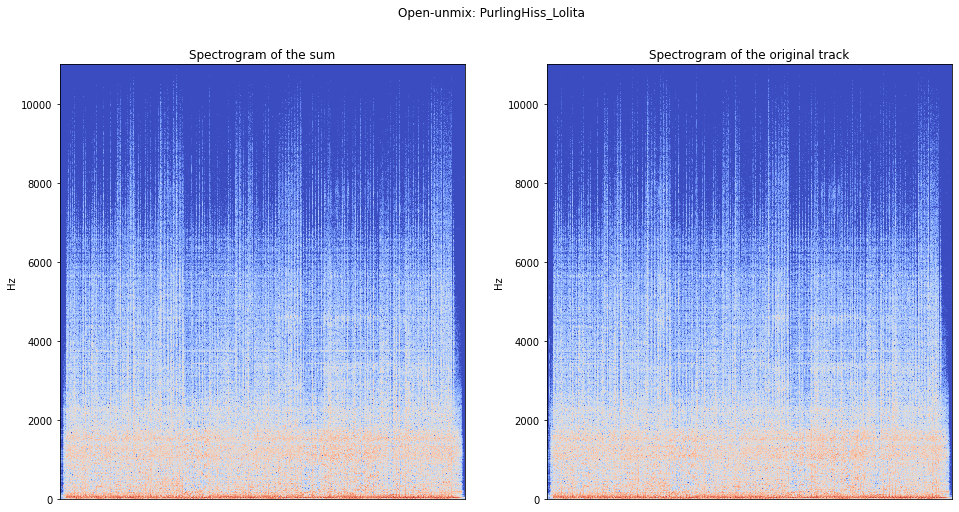

In [29]:
visualize_spectrum(audio, sum_open_unmix, 'Open-unmix: {}'.format(song_name))

`At this point, both models are still in memory and occupy around 6Gb of RAM.
One might consider reloading a kernel and reading the saved tracks from disk.`

# Phase 2: Mixing
---

In [4]:
from model_tdd import MixingModelTDD
from inference_utils import mix_song, mix_song_ifft
from dataset import MultitrackAudioDataset

In [18]:
weights = './weights/mixmodel_tdd_1s_0009_0.1616.pt'

# length of song chunks (in seconds), used for model training
chunk_length = 1

In [19]:
model = MixingModelTDD().to(device)
model.load_state_dict(torch.load(weights, map_location=device))

# set the model in the eval() mode - influences BatchNorm layer,
# but not gradients
model.eval()

MixingModelTDD(
  (conv1_1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (f_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(16, 26, kernel_size=(5, 3), stride=(1, 1))
  (conv2_2): Conv2d(26, 24, kernel_size=(5, 3), stride=(1, 1))
  (f_pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3_2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (f_pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tdd1): Conv2d(48, 1, kernel_size=(123, 1), 

In [20]:
# dataset.compute_features() is needed for mixing a song
d = MultitrackAudioDataset(
    base_dir,
    songlist=[song_name],
    chunk_length=chunk_length
)

---
## Experiment A:
```original stems --> mixing```

In [14]:
# load original multitracks 
loaded_tracks = {}

for track in d.get_tracklist():
    if track == 'mix':
        track_path = os.path.join(base_dir, song_name, '{}_MIX.wav'.format(song_name))
    else:
        track_path = os.path.join(base_dir, song_name, '{}_STEMS_JOINED'.format(song_name),
                                  '{}_STEM_{}.wav'.format(song_name, track.upper()))

    loaded_tracks[track], _ = librosa.load(track_path, sr=44100)

### Unmixed sum of multitracks

In [ ]:
sum_audio = np.zeros_like(loaded_tracks['drums'])

for track in d.get_tracklist():
    if track != 'mix':
        sum_audio += loaded_tracks['{}'.format(track)]

librosa.display.waveplot(sum_audio)
ipd.Audio(sum_audio, rate=44100)

### Ground-truth mix

In [ ]:
# ground truth mix
librosa.display.waveplot(loaded_tracks['mix'])
ipd.Audio(loaded_tracks['mix'], rate=44100)

In [ ]:
# mixing using a scalar model
with torch.no_grad():
    mixed_song = mix_song_ifft(d, model)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44032)

In [ ]:
# mixing using a vector model
with torch.no_grad():
    mixed_song = mix_song(d, model_vector, loaded_tracks, chunk_length=1)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44100)

---
## Experiment B:
```open-unmix separation --> mixing```

In [26]:
# load separated stems by Open-unmix
loaded_tracks = {}
results_path = os.path.join('output', 'open-unmix', song_name)

for track in ['bass', 'drums', 'other', 'vocals']:
    track_path = os.path.join(results_path, '{}.wav'.format(track,))
    loaded_tracks[track], _ = librosa.load(track_path, sr=44100)

In [ ]:
# mixing using a scalar model
with torch.no_grad():
    mixed_song = mix_song(d, model_scalar, loaded_tracks, chunk_length=1)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44100)

In [ ]:
# mixing using a vector model
with torch.no_grad():
    mixed_song = mix_song(d, model_vector, loaded_tracks, chunk_length=1)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44100)

---
## Experiment C:
```spleeter separation --> mixing```

In [29]:
# load separated stems by Spleeter
loaded_tracks = {}
results_path = os.path.join('output', 'spleeter', song_name)

for track in ['bass', 'drums', 'other', 'vocals']:
    track_path = os.path.join(results_path, '{}.wav'.format(track,))
    loaded_tracks[track], _ = librosa.load(track_path, sr=44100)

# add original mix
loaded_tracks['mix'] = librosa.load(os.path.join(base_dir, song_name, '{}_MIX.wav'.format(song_name)), sr=44100)

In [ ]:
# mixing using a scalar model
with torch.no_grad():
    mixed_song = mix_song(d, model_scalar, loaded_tracks, chunk_length=1)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44100)

In [ ]:
# mixing using a vector model
with torch.no_grad():
    mixed_song = mix_song(d, model_vector, loaded_tracks, chunk_length=1)

librosa.display.waveplot(mixed_song)
ipd.Audio(mixed_song, rate=44100)